<a id='home'></a>
### purpose

look at cross-validation another way - instead of looking at the distribution of validation scores from out-of-bag populations not used in training across k-fold sampling, instead look at the relationship between the union of out-of-bag offset predictions with that of the model using all populations - if there is not a strong relationship, the model is sensitive to population input

### outline

[1. read in population data](#read)

[2. read in kfold assignments](#kfold)

[3. extract offset values from netCDF files](#netcdf)

[4. combine offsets from k-folds into one set](#comb)

[5. look at relationships between kfold and full models](#comp)

In [1]:
from pythonimports import *
from myfigs import save_pdf

from matplotlib.lines import Line2D

fig_dir = '/data/projects/pool_seq/phenotypic_data/offset_misc_files/results/raw_validation'

lview,dview = get_client()

latest_commit()
session_info.show()

43 43
##################################################################
Current commit of pythonimports:
commit 51393d65f6b4f97bf9245fc37ae3c0a6cb41ca6b  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Mon Sep 12 14:32:41 2022 -0400
Today:	September 15, 2022 - 11:01:49
python version: 3.8.5
##################################################################



<a id='read'></a>
# 1. read in population data

(code from 11_validate_GF_offset_predictions.ipynb)

[top](#home)

### jack pine popdata

In [2]:
envdata = {}
envdata['jp'] = pd.read_table('/data/projects/pool_seq/environemental_data/jp_rm_p24/jp_no-p24_std_env-19variables.txt')
envdata['jp'].index = envdata['jp']['our_id'].tolist()
envdata['jp'].head()

,id1,id2,our_id,LAT,LONG,Elevation,AHM,CMD,DD5,DD_0,EMT,EXT,Eref,FFP,MAP,MAT,MCMT,MSP,MWMT,NFFD,PAS,SHM,TD,bFFP,eFFP,group_color
JP_p98,9150251,38,JP_p98,54.3333,-106.6333,537,0.675175,0.520607,-0.903668,1.089738,-0.977280,-0.426821,-0.730607,-0.884497,-1.150172,-1.078601,-0.980098,-1.159142,-0.873067,0.024306,-0.875072,0.771358,0.796677,0.297097,-1.185008,green
JP_p73,3273,22,JP_p73,44.4200,-84.6800,359,0.836472,1.368359,1.495515,-1.369016,1.486357,0.679033,1.970275,1.047245,-0.089609,1.506884,1.449041,0.000330,1.202338,0.909053,-0.778393,0.304132,-1.205688,-0.729581,1.010494,blue
JP_p97,8060006,37,JP_p97,56.1167,-116.9167,636,1.138905,1.382488,-1.202248,0.719680,-0.625332,-0.368618,-0.448998,-1.781378,-1.263664,-0.914443,-0.919871,-1.584282,-1.651344,-0.670852,-0.839916,0.994352,0.436701,0.737103,-2.282760,green
JP_p60,3260,17,JP_p60,46.7200,-84.3900,203,-0.272448,-0.129337,0.093943,-0.869081,0.927381,-0.659632,0.101418,0.495318,0.364358,0.645056,0.907002,0.026096,-0.224503,0.466680,0.320236,-0.311756,-1.093195,0.150429,1.010494,blue
JP_p100,9040116,40,JP_p100,55.7667,-97.8167,205,-0.917638,-0.199983,-1.852100,2.404514,-1.743285,-0.135807,-1.831440,-2.333304,-0.974064,-2.350824,-1.943723,-1.030312,-1.456774,-2.693131,-0.330152,0.293514,1.674118,2.497123,-1.843659,green


### doug-fir pop data

In [3]:
# map prov ID to our ID to translate pop names in phenotype data below
envdata['combined'] = pd.read_table('/data/projects/pool_seq/environemental_data/change_p6/df_ALL-naturalpops_raw_env-19variables_change-p6.txt')
envdata['combined'].index = envdata['combined']['our_id'].tolist()
provdict = dict(zip(envdata['combined']['prov'], envdata['combined']['our_id']))
print(provdict)

{1: 'DF_p1', 2: 'DF_p2', 3: 'DF_p3', 4: 'DF_p4', 5: 'DF_p5', 6: 'DF_p6', 7: 'DF_p7', 8: 'DF_p8', 9: 'DF_p9', 10: 'DF_p10', 11: 'DF_p11', 12: 'DF_p12', 13: 'DF_p13', 14: 'DF_p14', 15: 'DF_p15', 16: 'DF_p16', 17: 'DF_p17', 18: 'DF_p18', 19: 'DF_p19', 20: 'DF_p20', 23: 'DF_p23', 24: 'DF_p24', 25: 'DF_p25', 26: 'DF_p26', 27: 'DF_p27', 28: 'DF_p28', 29: 'DF_p29', 30: 'DF_p30', 31: 'DF_p31', 32: 'DF_p32', 33: 'DF_p33', 34: 'DF_p34', 35: 'DF_p35', 36: 'DF_p36', 37: 'DF_p37', 38: 'DF_p38', 39: 'DF_p39', 40: 'DF_p40', 41: 'DF_p41', 42: 'DF_p42', 43: 'DF_p43', 44: 'DF_p44', 45: 'DF_p45', 46: 'DF_p46', 47: 'DF_p47', 48: 'DF_p48', 49: 'DF_p49', 50: 'DF_p50', 51: 'DF_p51', 52: 'DF_p52', 53: 'DF_p53', 54: 'DF_p54', 55: 'DF_p55', 56: 'DF_p56', 57: 'DF_p57', 58: 'DF_p58', 59: 'DF_p59', 60: 'DF_p60', 61: 'DF_p61', 62: 'DF_p62', 72: 'DF_p72', 73: 'DF_p73', 74: 'DF_p74', 75: 'DF_p75', 76: 'DF_p76', 77: 'DF_p77', 78: 'DF_p78', 79: 'DF_p79', 80: 'DF_p80', 81: 'DF_p81', 82: 'DF_p82', 83: 'DF_p83', 84: 'DF_p

In [4]:
# coastal
envdata['fdc'] = envdata['combined'][envdata['combined']['Variety']=='FDC'].copy()
nrow(envdata['fdc'])

38

In [5]:
# interior
envdata['fdi'] = envdata['combined'][envdata['combined']['Variety']=='FDI'].copy()
nrow(envdata['fdi'])

35

In [6]:
assert nrow(envdata['fdi']) + nrow(envdata['fdc']) == nrow(envdata['combined'])

In [7]:
# create color dict for pop colors
cdict = dict(zip(envdata['jp'].index,
                 envdata['jp']['group_color']))

df_colors = pd.read_table('/data/projects/pool_seq/environemental_data/change_p6/doug-fir_colored_pops.txt')
df_colors.loc[df_colors['our_id']=='DF_p40', ['group', 'group_color']] = 'North BC', '#f205f4'  # as in ../01_split_training_and_testing.ipynb

cdict.update(dict(
    zip(df_colors['our_id'],
        df_colors['group_color'])
))


assert len(cdict) == nrow(envdata['jp']) + nrow(envdata['combined'])

In [8]:
# from ../08_climate_and_geographic_distance_vs_phenotypes.ipynb#calc
# separate interior into two genetic groups seen in PCA
western_groups = ['North BC', 'South Central BC']

fdi_envdata = envdata['fdi'].copy()
group_dict = dict(zip(df_colors['our_id'], df_colors['group']))
fdi_envdata['group'] = fdi_envdata['our_id'].map(group_dict)
fdi_envdata['genetic_group'] = ['western' if group in western_groups else 'eastern' for group in fdi_envdata['group']]

fdi_groups = fdi_envdata[['our_id', 'genetic_group']].groupby('genetic_group')['our_id'].apply(list).to_dict()
print(fdi_groups)

{'eastern': ['DF_p3', 'DF_p5', 'DF_p18', 'DF_p19', 'DF_p20', 'DF_p33', 'DF_p34', 'DF_p37', 'DF_p46', 'DF_p47', 'DF_p54', 'DF_p55', 'DF_p56', 'DF_p57', 'DF_p58', 'DF_p59', 'DF_p60', 'DF_p61', 'DF_p62'], 'western': ['DF_p4', 'DF_p7', 'DF_p8', 'DF_p9', 'DF_p35', 'DF_p36', 'DF_p38', 'DF_p39', 'DF_p40', 'DF_p41', 'DF_p42', 'DF_p43', 'DF_p44', 'DF_p45', 'DF_p48', 'DF_p49']}


<a id='kfold'></a>
# 2. read in kfold assignments

(code from 11_validate_GF_offset_predictions.ipynb)

[top](#home)

In [9]:
offset_dir = '/data/projects/pool_seq/phenotypic_data/offset_misc_files'
testtrain = pklload(op.join(offset_dir, 'train_test_assignment_for_kfold_crossval.pkl'))

for spp, df in testtrain.items():
    if spp == 'wl':
        continue
        
    print(spp)
    df['full'] = True

df.head()

fdc
fdi
combined
jp


,k1 training,k2 training,k3 training,k4 training
WL_p272,True,True,False,True
WL_p281,True,True,True,False
WL_p285,True,True,True,False
WL_p287,True,False,True,True
WL_p291,True,True,True,False


<a id='netcdf'></a>
# 3. extract offset values from netCDF files

(code from 11_validate_GF_offset_predictions.ipynb)

[top](#home)

In [10]:
def read_offset_file(offset_file, x_dim="latitude", y_dim="longitude"):
    """Read in netcdf file."""
    import xarray as xr
    import rioxarray

    ds = xr.open_dataset(offset_file)
    ds.rio.set_spatial_dims(x_dim=x_dim, y_dim=y_dim, inplace=True)
    ds.rio.write_crs("epsg:4326", inplace=True)
    
    layers = [var for var in list(ds.variables) if var not in ['crs', 'longitude', 'latitude']]
    assert len(layers) == 1
    layer = layers[0]
    vals = ds[layer][:,:]
    lons = ds[layer]['longitude']
    lats = ds[layer]['latitude']
    
    return ds, layer, vals, lons, lats
dview['read_offset_file'] = read_offset_file


def get_offset_data(offset_file, envdata, latcol='LAT', loncol='LONG'):
    """Read in offset data from netCDF `offset_file` for each of the pops in `envdata`."""
    import xarray as xr

    # read in offset data
    ds,layer,*args = read_offset_file(offset_file)

    # pull offset values directly from the shapefile
    target_lat = xr.DataArray(envdata[latcol], dims='points')
    target_lon = xr.DataArray(envdata[loncol], dims='points')
    offsets = ds[layer].sel(longitude=target_lon, latitude=target_lat, method='nearest').to_dataframe()
    offsets.index = envdata['our_id'].tolist()
    
    try:
        assert offsets[offsets.columns[-1]].isnull().sum() == 0
    except AssertionError as e:
        # there can be null vals if a population resides outside of the shapefile boundaries ...
        # ... when shapefiles have been used to clip climate data
        print(offset_file, envdata.index)
        raise e

    return offsets


In [11]:
# get the files that contain the offset information
fitting_dir = '/data/projects/pool_seq/phenotypic_data/offset_misc_files/fitting'
ncfiles = fs(fitting_dir, endswith='.nc', exclude=['NA_', 'wl-'])  # added exclusion of WL
len(ncfiles)

138

In [12]:
# for each of the netCDF files, partition into garden, species, dataset (wza/baypass/random), and whether ...
# ... it's one of the k-fold cross-validation sets or the full (no test set) dataset
# raw_offset[garden][spp][dataset][k_or_full] = f
raw_offset = wrap_defaultdict(None, 4)
species = []
for f in ncfiles:
    spp,method,setname,kfold,*args = op.basename(f).rstrip(".txt").split("-")
    kfold = kfold.split("_gradient")[0]
    garden = args[0].split("_")[0]
    dataset = '-'.join([method, setname])
    
    assert garden in ['vancouver', 'christine', 'fontbrune']
    assert spp in ['wl', 'jp', 'fdi', 'fdc', 'combined']
    assert kfold in ['full', 'k1', 'k2', 'k3', 'k4']
    
    species.append(spp)
    raw_offset[garden][spp][dataset][kfold] = f

for garden,sppdict in raw_offset.items():
    for spp,datadict in sppdict.items():
        for dataset,kdict in datadict.items():
            print(garden, spp, dataset, len(kdict), keys(kdict))

vancouver combined baypass-pseudo_random_loci 5 ['full', 'k1', 'k2', 'k3', 'k4']
vancouver combined baypass-random 5 ['full', 'k1', 'k2', 'k3', 'k4']
vancouver combined baypass-real 5 ['full', 'k1', 'k2', 'k3', 'k4']
vancouver combined wza-pseudo_random_loci 5 ['full', 'k1', 'k2', 'k3', 'k4']
vancouver combined wza-random 5 ['full', 'k1', 'k2', 'k3', 'k4']
vancouver combined wza-real 5 ['full', 'k1', 'k2', 'k3', 'k4']
vancouver fdc baypass-pseudo_random_loci 5 ['full', 'k1', 'k2', 'k3', 'k4']
vancouver fdc baypass-random 5 ['full', 'k1', 'k2', 'k3', 'k4']
vancouver fdc baypass-real 5 ['full', 'k1', 'k2', 'k3', 'k4']
vancouver fdc wza-pseudo_random_loci 5 ['full', 'k1', 'k2', 'k3', 'k4']
vancouver fdc wza-random 5 ['full', 'k1', 'k2', 'k3', 'k4']
vancouver fdc wza-real 5 ['full', 'k1', 'k2', 'k3', 'k4']
vancouver fdi baypass-pseudo_random_loci 5 ['full', 'k1', 'k2', 'k3', 'k4']
vancouver fdi baypass-random 5 ['full', 'k1', 'k2', 'k3', 'k4']
vancouver fdi baypass-real 5 ['full', 'k1', 'k

In [13]:
# retrieve offset data in parallel
jobs = []
arg_order = []
for garden,sppdict in raw_offset.items():
    for spp,datadict in sppdict.items():
        latcol = 'LAT' #if spp != 'wl' else 'Latitude'
        loncol = 'LONG' #if spp != 'wl' else 'Longitude'
        for dataset,kdict in datadict.items():
            for kfold,f in kdict.items():
                arg_order.append([garden, spp, dataset, kfold, f])
                jobs.append(
                    lview.apply_async(
                        get_offset_data, *(f, envdata[spp]), **dict(latcol=latcol, loncol=loncol)
                    )
                )
watch_async(jobs)


Watching 138 jobs ...


100%|███████████████| 138/138 [00:00<00:00, 481142.10it/s]


In [14]:
# get job returns, store in dict
offsets = wrap_defaultdict(None, 4)
for i,job in enumerate(jobs):
    garden,spp,dataset,kfold,f = arg_order[i]
    df = job.r
    offsets[garden][spp][dataset][kfold] = df.copy()

df.head()

,crs,longitude,latitude,X..Downloads.NA_ENSEMBLE_rcp45_2050s.TD_WGS84_clipped_jp.tif
JP_p98,0,-106.627715,54.323131,0.064699
JP_p73,0,-84.675644,44.410801,0.045147
JP_p97,0,-116.914096,56.123248,0.063981
JP_p60,0,-84.395107,46.725237,0.024951
JP_p100,0,-97.814158,55.772576,0.082029


<a id='comb'></a>
# 4. combine offsets from k-folds into one set

[top](#home)

In [15]:
kfold_union = wrap_defaultdict(pd.Series(dtype=float).copy, 3)
for (garden, spp, dataset, kfold), offset in unwrap_dictionary(offsets):
    if kfold != 'full':
        # get the boolean list of whether populations (rows) were in the kfold training set (cols)
        testtrain_info = testtrain[spp][f'{kfold} training'].copy()
        
        # get the pops that were out-of-bag
        outofbag = testtrain_info.index[testtrain_info == False]
        
        # make sure I'm doing what I think I'm doing (adding non-overlapping lists together)
        assert len(set(outofbag).intersection(kfold_union[garden][spp][dataset].index)) == 0
        
        # add out-of-bag scores to list
        for pop in outofbag:
            kfold_union[garden][spp][dataset].loc[pop] = offset.loc[pop, offset.columns[-1]]


### map pop to kfold for easier look-ups

In [16]:
pop2k = defaultdict(dict)
for spp, kfold_df in testtrain.items():
    if spp == 'wl':  # bye felicia
        continue
        
    for col, testtrain_info in kfold_df.iteritems():
        # kfold ID
        kfold = col.split()[0]
        
        # get the pops that were out-of-bag
        outofbag = testtrain_info.index[testtrain_info == False]
        
        # map pop to kfold
        for pop in outofbag:
            assert pop not in keys(pop2k[spp])
            pop2k[spp][pop] = kfold

    # ensure I recoved exactly the number of pops that I expected to
    assert nrow(envdata[spp]) == len(pop2k[spp])

'combined', len(pop2k['combined']), Counter(pop2k['combined'].values())

('combined', 73, Counter({'k1': 19, 'k2': 18, 'k3': 18, 'k4': 18}))

In [17]:
# map kfold to shape
kshape = {'k1' : 'v',  # triangle down
          'k2' : '^',  # triangle up
          'k3' : 's',  # square
          'k4' : '8'  # octagon
         }

# map pop to shape for figure below
popshape = defaultdict(dict)
for (spp, pop), kfold in unwrap_dictionary(pop2k):
    popshape[spp][pop] = kshape[kfold]
    
popshape['jp']['JP_p73']

'v'

<a id='comp'></a>
# 5. look at relationships between kfold and full models

[top](#home)

In [18]:
keys(kfold_union[garden][spp])

['baypass-pseudo_random_loci',
 'baypass-random',
 'baypass-real',
 'wza-pseudo_random_loci',
 'wza-random',
 'wza-real']

vancouver combined baypass-random
rho = 0.9379
Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/raw_validation/combined_vancouver_baypass-random_kfold_comparison.pdf


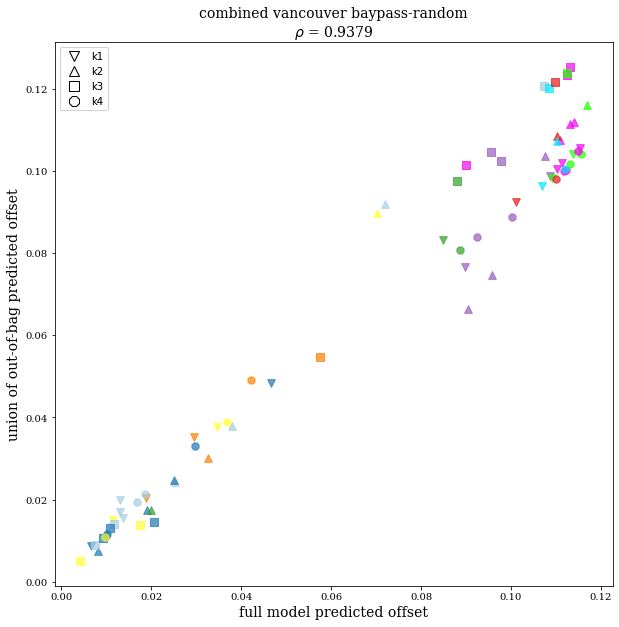

vancouver combined baypass-real
rho = 0.9632
Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/raw_validation/combined_vancouver_baypass-real_kfold_comparison.pdf


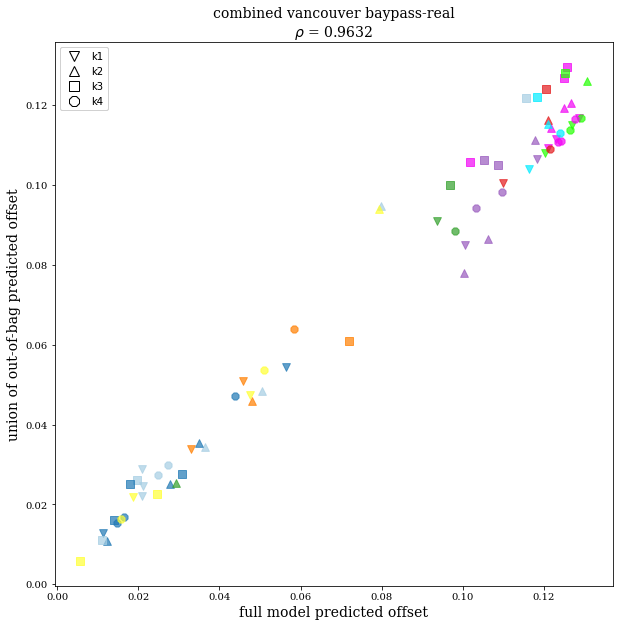

vancouver combined wza-random
rho = 0.9345
Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/raw_validation/combined_vancouver_wza-random_kfold_comparison.pdf


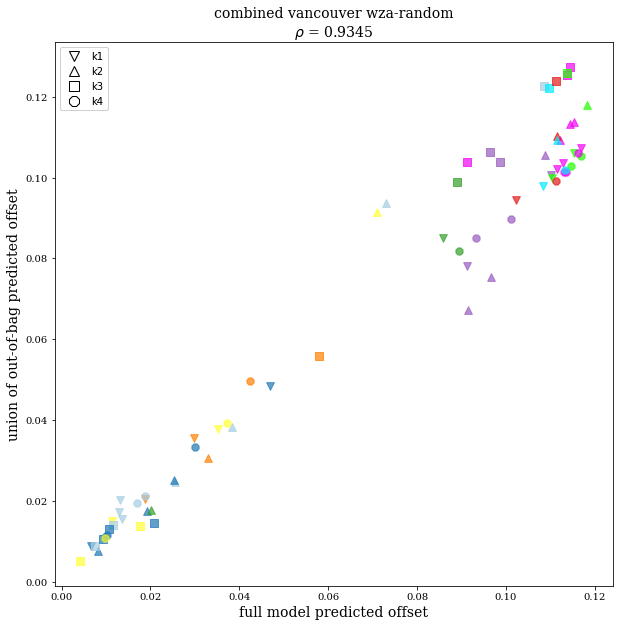

vancouver combined wza-real
rho = 0.9526
Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/raw_validation/combined_vancouver_wza-real_kfold_comparison.pdf


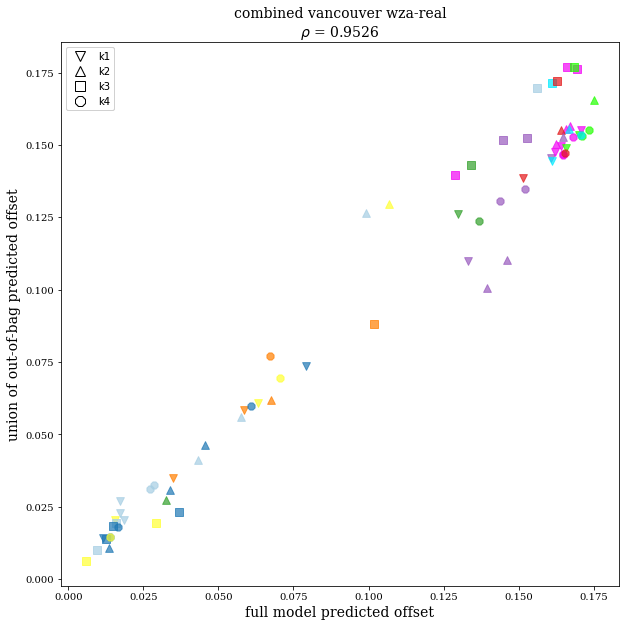

vancouver fdc baypass-random
rho = 0.9621
Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/raw_validation/fdc_vancouver_baypass-random_kfold_comparison.pdf


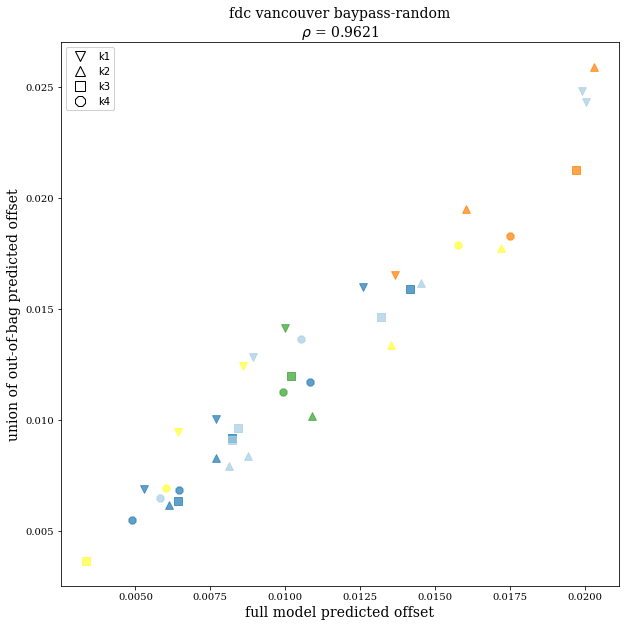

vancouver fdc baypass-real
rho = 0.921
Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/raw_validation/fdc_vancouver_baypass-real_kfold_comparison.pdf


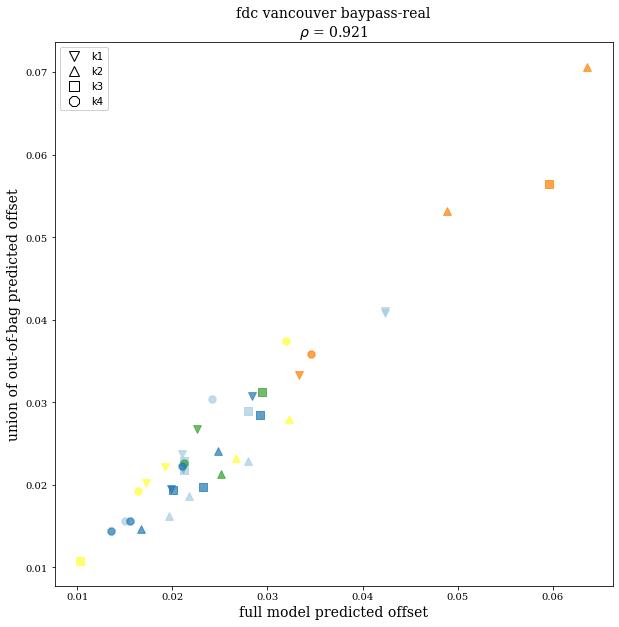

vancouver fdc wza-random
rho = 0.9575
Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/raw_validation/fdc_vancouver_wza-random_kfold_comparison.pdf


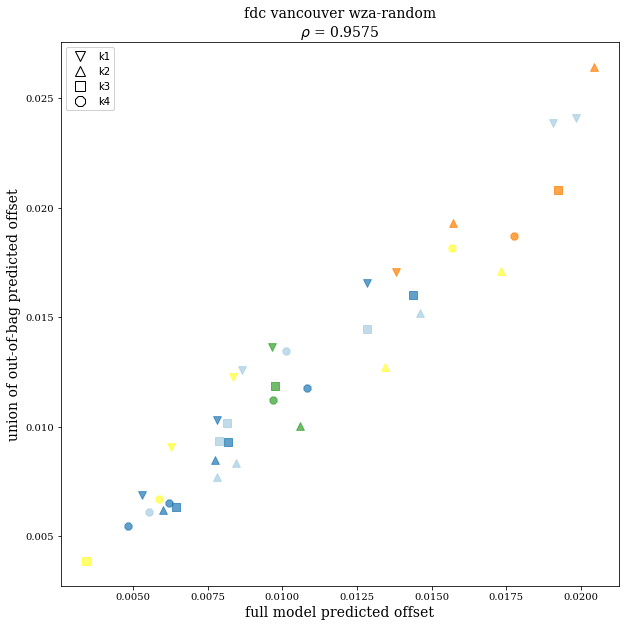

vancouver fdc wza-real
rho = 0.9462
Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/raw_validation/fdc_vancouver_wza-real_kfold_comparison.pdf


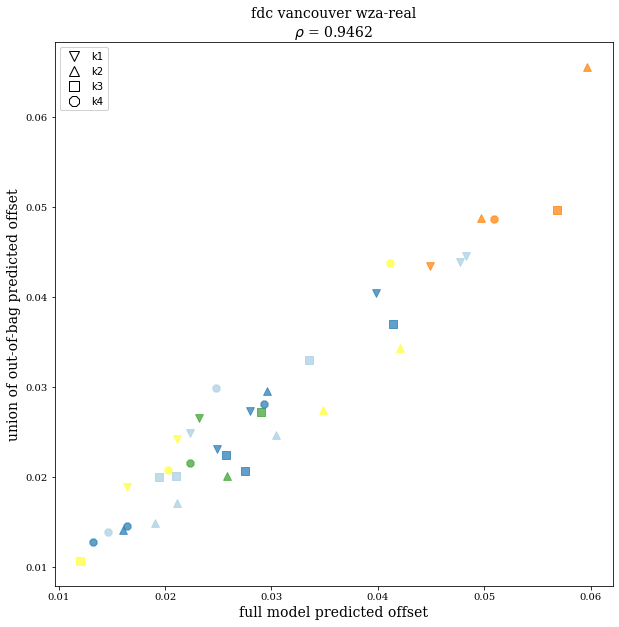

vancouver fdi baypass-random
rho = 0.5081
Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/raw_validation/fdi_vancouver_baypass-random_kfold_comparison.pdf


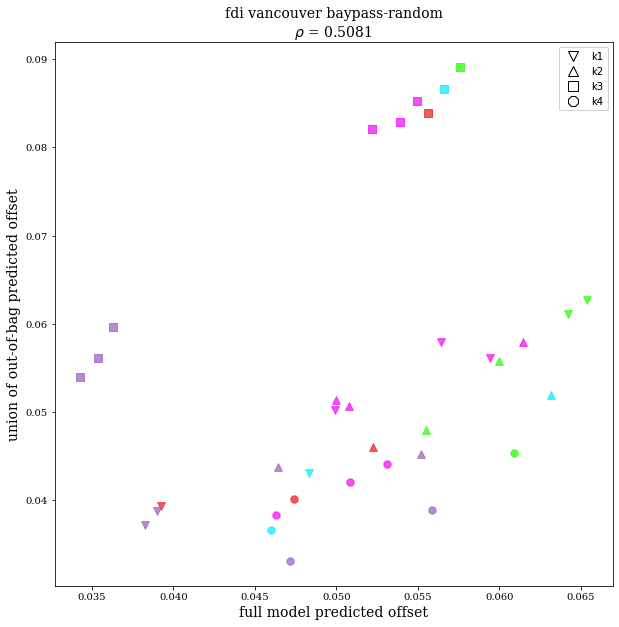

vancouver fdi baypass-real
rho = 0.709
Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/raw_validation/fdi_vancouver_baypass-real_kfold_comparison.pdf


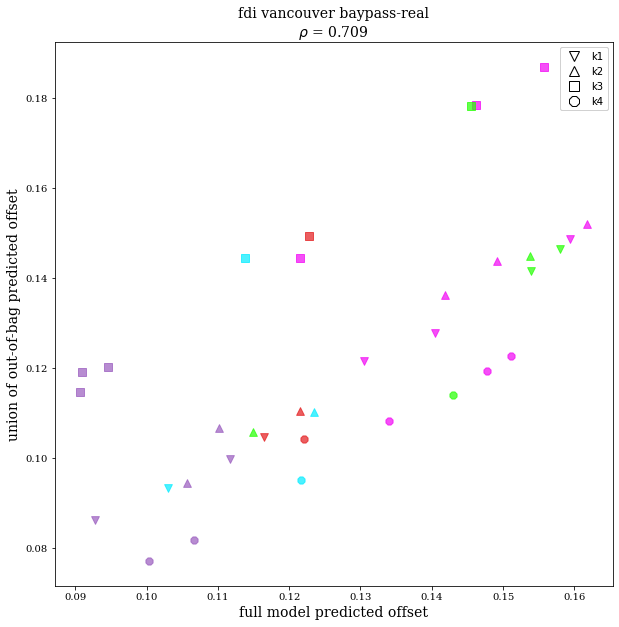

vancouver fdi wza-random
rho = 0.5053
Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/raw_validation/fdi_vancouver_wza-random_kfold_comparison.pdf


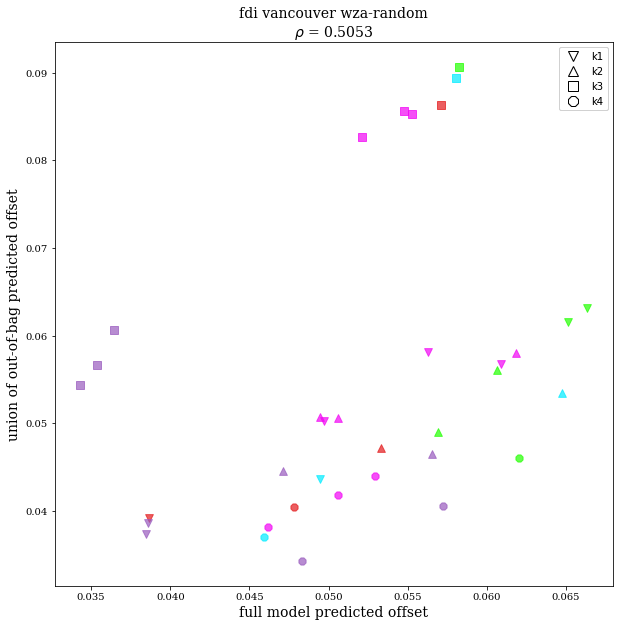

vancouver fdi wza-real
rho = 0.4361
Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/raw_validation/fdi_vancouver_wza-real_kfold_comparison.pdf


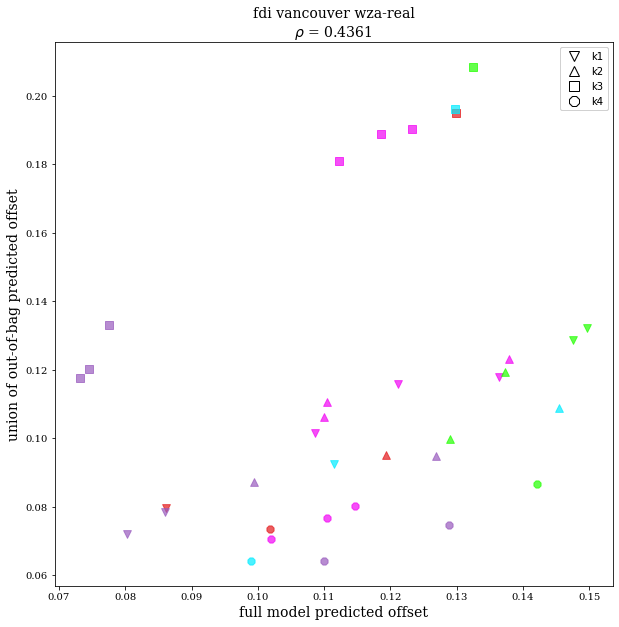

christine jp baypass-random
rho = 0.9441
Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/raw_validation/jp_christine_baypass-random_kfold_comparison.pdf


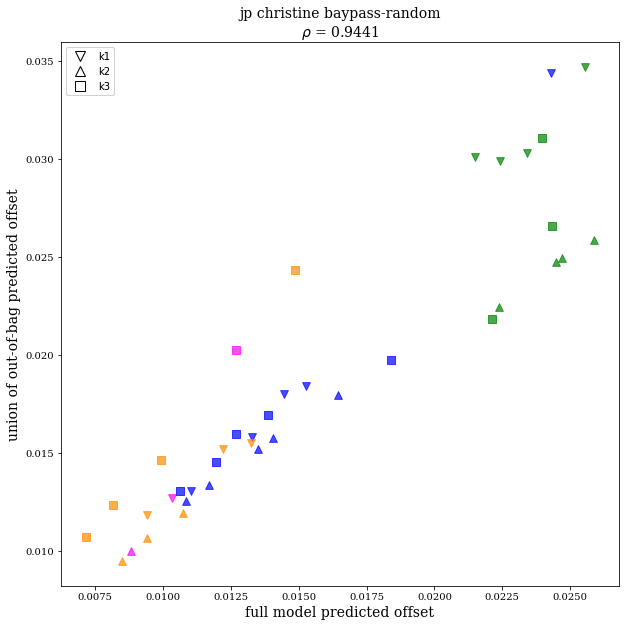

christine jp baypass-real
rho = 0.9407
Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/raw_validation/jp_christine_baypass-real_kfold_comparison.pdf


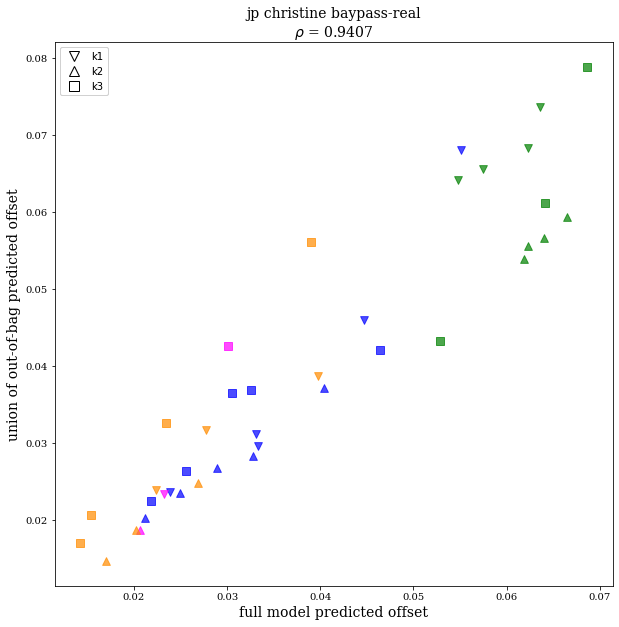

christine jp wza-random
rho = 0.9381
Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/raw_validation/jp_christine_wza-random_kfold_comparison.pdf


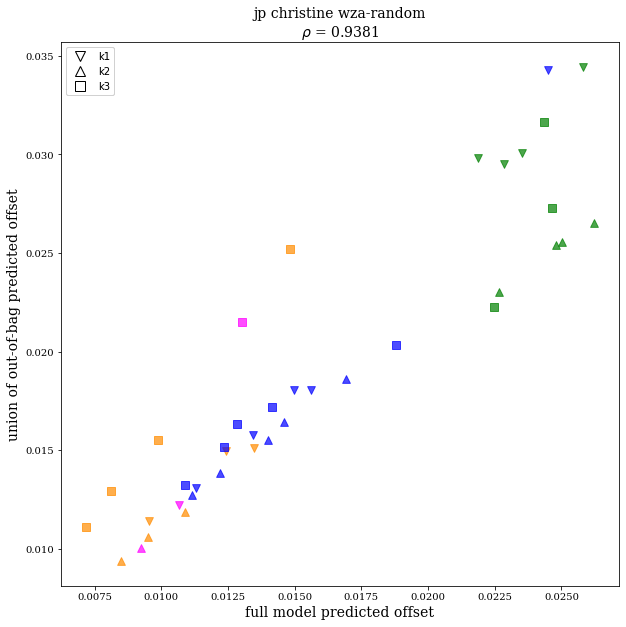

christine jp wza-real
rho = 0.9482
Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/raw_validation/jp_christine_wza-real_kfold_comparison.pdf


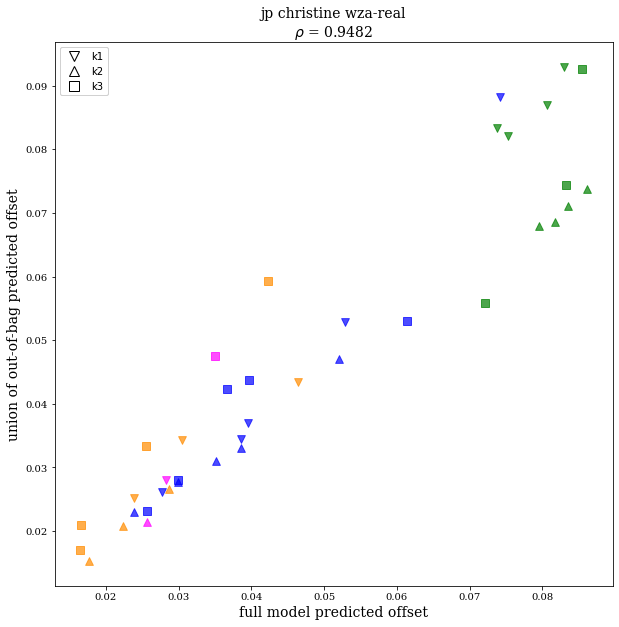

fontbrune jp baypass-random
rho = 0.9285
Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/raw_validation/jp_fontbrune_baypass-random_kfold_comparison.pdf


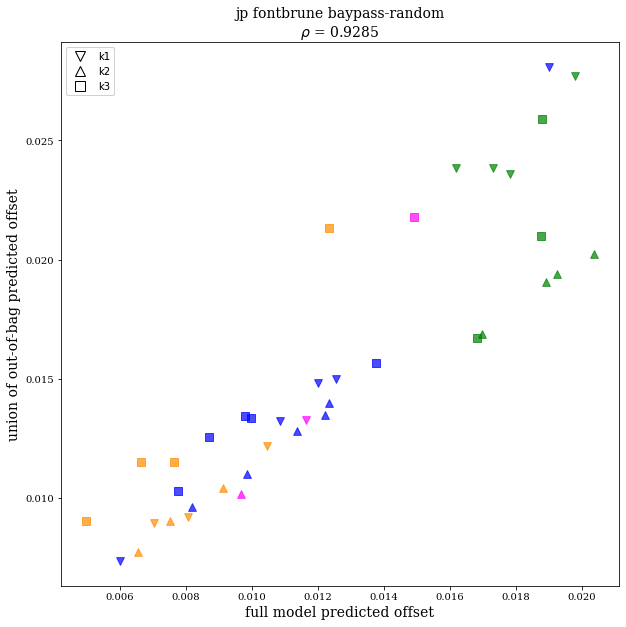

fontbrune jp baypass-real
rho = 0.8883
Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/raw_validation/jp_fontbrune_baypass-real_kfold_comparison.pdf


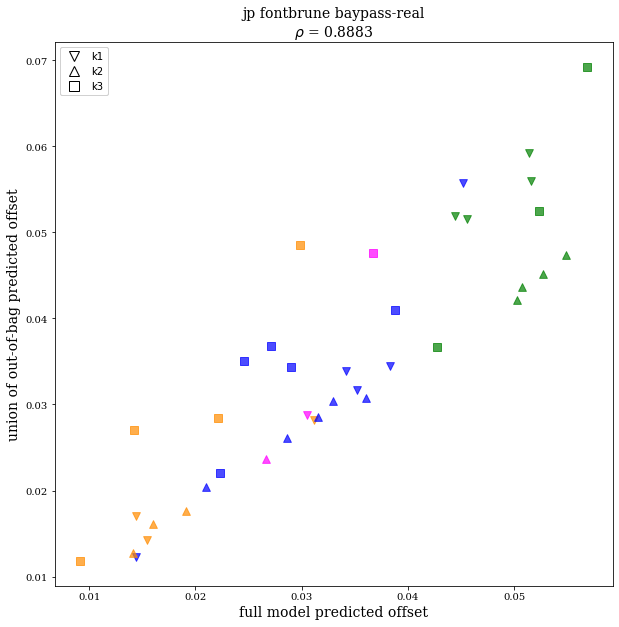

fontbrune jp wza-random
rho = 0.9014
Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/raw_validation/jp_fontbrune_wza-random_kfold_comparison.pdf


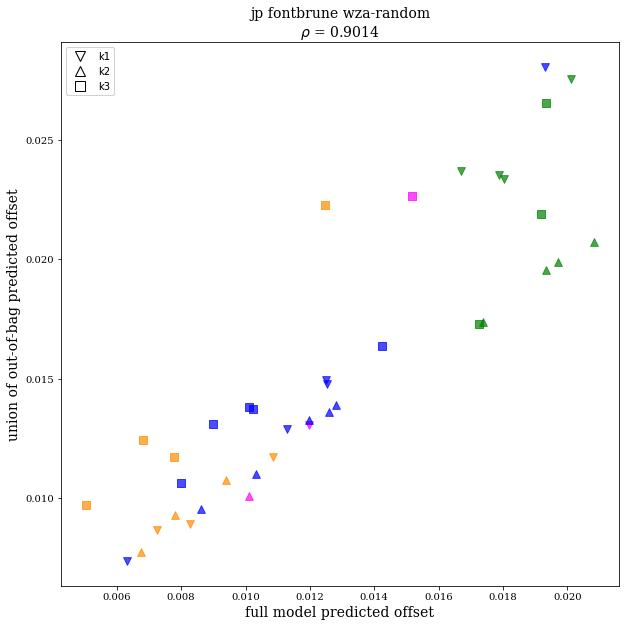

fontbrune jp wza-real
rho = 0.9071
Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/results/raw_validation/jp_fontbrune_wza-real_kfold_comparison.pdf


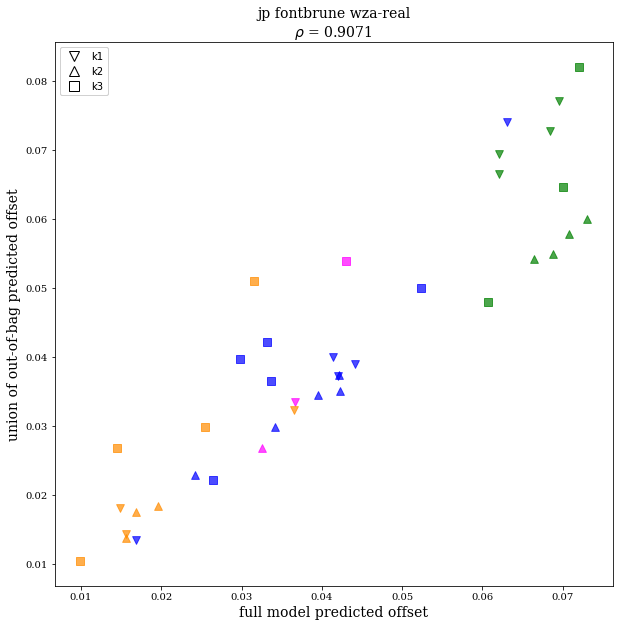

In [20]:
for (garden, spp, dataset), union in unwrap_dictionary(kfold_union):    
    if 'pseudo' in dataset:
        continue
    
    print(garden, spp, dataset)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    full_model_offset = offsets[garden][spp][dataset]['full'].copy()
    
    rho = round(full_model_offset[full_model_offset.columns[-1]].corr(union, method='spearman'),
                4)
    print(f'{rho = }')
    
    for pop in union.index:
        pathCollection = ax.scatter(full_model_offset[full_model_offset.columns[-1]].loc[pop],
                                    union.loc[pop],
                                    c=cdict[pop],
                                    marker=popshape[spp][pop],
                                    s=60,
                                    alpha=0.7
                                   )

    # add legend
    unique_kfolds = sorted(uni(pop2k[spp].values()))
    
    # make fig pretty
    ax.set_xlabel('full model predicted offset', fontdict=dict(size=14, family='serif'))
    plt.setp(ax.get_xticklabels(), family='serif')  # set xtick font
    
    ax.set_ylabel('union of out-of-bag predicted offset', fontdict=dict(size=14, family='serif'))
    plt.setp(ax.get_yticklabels(), family='serif')  # set ytick font
    
    ax.set_title(f'{spp} {garden} {dataset}\n$\\rho$ = {rho}', fontdict=dict(size=14, family='serif'))
    
    # add legend
    # shapes and labels for the offset source
    handles = []
    for kfold in unique_kfolds:
        handles.append(
            Line2D([0], [0], marker=kshape[kfold], color='none', markerfacecolor='none',
                   markeredgecolor='k', label=kfold, markersize=10)
        )
    leg = ax.legend(handles=handles, loc='best')
    ax.add_artist(leg)

    # save
    saveloc = op.join(fig_dir, f'{spp}_{garden}_{dataset}_kfold_comparison.pdf')
    save_pdf(saveloc)
    
    plt.show()

[top](#home)